In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import xgboost as xgb

#Hyperparameter Tuning
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

# Package to visualize Decision Tree
from sklearn import tree
from sklearn.tree import plot_tree

from IPython.display import Markdown, display
import pickle
import time

# Reading in Data

In [2]:
data = pd.read_csv("Data Files/Clean_Data_for_ML.csv")
data.tail(10)

,Tm,Capacity,Week,Attendance,Year,Away Team Wins,Home Team Wins,Time,International
2480,IND,67000,18,65925,2023,9,9,4,0
2481,LAC,70240,18,68274,2023,10,5,0,0
2482,LV,65000,18,61429,2023,8,7,0,0
2483,MIA,65326,18,66292,2023,10,11,1,0
2484,NE,66829,18,64628,2023,6,4,0,0
2485,NO,73208,18,70072,2023,7,8,0,0
2486,NYG,82500,18,75740,2023,11,5,0,0
2487,SF,68500,18,71624,2023,9,12,0,0
2488,TEN,69143,18,63744,2023,9,5,0,0
2489,WAS,67717,18,63645,2023,11,4,0,0


## Data Partitioning

In [84]:
# Setting up Independent and Dependent Variables
predictors = ["Capacity", "Week", "Away Team Wins", "Home Team Wins", "Time", "International"]
outcome = "Attendance"

data["Time"] = data["Time"].astype(str)

x = pd.get_dummies(data[predictors], drop_first = True)
y = data[outcome]

for i in range(1,5):
    x[f"Time_{i}"] = x[f"Time_{i}"].astype(int)


x.head()

,Capacity,Week,Away Team Wins,Home Team Wins,International,Time_1,Time_2,Time_3,Time_4
0,71608,1,0,0,0,0,0,0,0
1,74867,1,0,0,0,0,0,0,0
2,61500,1,0,0,0,0,0,0,0
3,67431,1,0,0,0,0,0,0,0
4,76125,1,0,0,0,0,0,1,0


In [4]:
y.head()

0    69519
1    73294
2    62213
3    71513
4    76977
Name: Attendance, dtype: int64

In [5]:
# Randomly splitting data into training set and testing set with 70/30 splits
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 100)

# Linear Regression Model

In [6]:
reg = LinearRegression()

reg.fit(train_x, train_y)

LinearRegression()

In [7]:
print(f"Y Intercept: {round(reg.intercept_, 4)} \n")
print(pd.DataFrame({'Predictor': x.columns, 'Coefficient': np.round(reg.coef_ ,1)}))

Y Intercept: 14253.7869 

        Predictor  Coefficient
0        Capacity          0.8
1            Week       -358.2
2  Away Team Wins        169.5
3  Home Team Wins        550.7
4   International       2913.4
5          Time_1        318.5
6          Time_2        888.4
7          Time_3        648.6
8          Time_4        778.5


This output reveals some inferential information. The capacity variable has almost a 1:1 relationship with Attendance. However, the relationship is slightly below 1. This makes sense because if all variables were controlled, Attendance would be 80% of the maximum capacity, which is not a terrible estimate. 

As the season progresses and the Week number increases, the Attendance decreases as a result. Intuitively this makes sense because there are many teams with hopeful fans at the start of the season. However, if those teams do not perform well, fans may get discouraged and not want to attend home games. Lastly, International Games have strong attendance, boasting a 2508 additional fan attendance than a game in the USA.

In [8]:
# Print Performance Measures for Training Data
train_y_pred = reg.predict(train_x)

r2_train = sklearn.metrics.r2_score(train_y, train_y_pred)

RMSE_train = sklearn.metrics.root_mean_squared_error(train_y, train_y_pred)

print('R-squared on Training Data: %0.2f' %r2_train)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Training Data: 0.58
RMSE on Train Set: 4465.28


In [9]:
# Test Performance Measures for Test Data
test_y_pred = reg.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, test_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, test_y_pred)

print('R-squared on Test Data: %0.2f' %r2_test)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Data: 0.65
RMSE on Test Set: 4200.52


Although the linear regression model performance is not spectacular, the training and test data performed similarly, meaning there is no underfitting or overfitting.

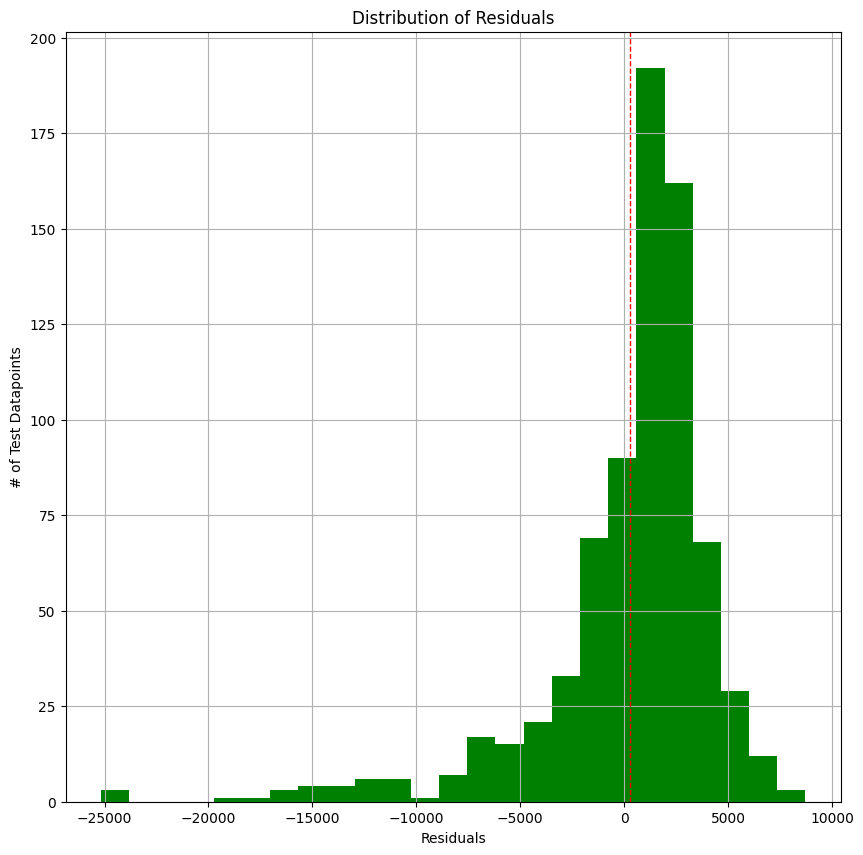

In [11]:
# Visualizing the distribution of Residuals
all_residuals = test_y - test_y_pred

pd.DataFrame({'Residuals': all_residuals}).hist(bins=25, figsize=(10,10), color = 'green')

plt.xlabel('Residuals')
plt.ylabel('# of Test Datapoints')
plt.title('Distribution of Residuals')
plt.axvline(all_residuals.mean(), color='red', linestyle='dashed', linewidth=1);

The distribution of residuals is skewed to the left. There are some instances where the model severly underpredicted attendance.

In [21]:
residual_df = pd.DataFrame({"Team": data.loc[test_x.index, "Tm"],
                            "Week": data.loc[test_x.index, "Week"], 
                            "Year": data.loc[test_x.index, "Year"], 
                            "Capacity": test_x["Capacity"], 
                            "Prediction": test_y_pred, 
                            "Actual": test_y,
                            "Residual": test_y - test_y_pred})
residual_df.sort_values(by = "Residual").head()

,Team,Week,Year,Capacity,Prediction,Actual,Residual
1054,LAR,5,2017,93607,85921.523739,60745,-25176.523739
1606,TB,10,2019,69218,65128.553890,40038,-25090.553890
1147,LAR,12,2017,93607,86633.794725,62006,-24627.794725
1558,CIN,7,2019,65515,62105.132719,42784,-19321.132719
1423,WAS,14,2018,82000,75826.834487,57437,-18389.834487


The top 5 most underpredicted instances.

# Decision Tree Model

In [92]:
tree = DecisionTreeRegressor(random_state = 99)

# Starting with an initial guess for parameters
hyper_params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [20, 40, 60],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

dec_tree_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [25]:
# Fit the model
dec_tree_cv.fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'min_samples_split': [20, 40, 60]},
             scoring='r2', verbose=1)

In [26]:
print(f"Initial score: {round(dec_tree_cv.best_score_, 4)}")
print(f"Initial parameters:{dec_tree_cv.best_params_}")

Initial score: 0.7573
Initial parameters:{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 60}


## Hyperparameter Tuning

In [93]:
# Adapt grid based on result from initial grid search
hyper_params_new = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_split': [50, 55, 60, 65, 70],
    'min_samples_leaf': [8, 10, 12]
}

dec_tree_cv = GridSearchCV(estimator = tree,
                        param_grid = hyper_params_new,
                        scoring = 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

In [94]:
# Re-fit the model
dec_tree_cv.fit(train_x, train_y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=99), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13],
                         'min_samples_leaf': [8, 10, 12],
                         'min_samples_split': [50, 55, 60, 65, 70]},
             scoring='r2', verbose=1)

In [95]:
print(f"Improved score: {round(dec_tree_cv.best_score_, 4)}")
print(f"Improved parameters:{dec_tree_cv.best_params_}")

Improved score: 0.7614
Improved parameters:{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 60}


In [107]:
# Storing best model
bestRegTree = dec_tree_cv.best_estimator_

fig.savefig("decision_tree.png", dpi=300, bbox_inches='tight')

In [97]:
# Print Performance Measures for Training Data

y_pred = dec_tree_cv.predict(train_x)
r2 = sklearn.metrics.r2_score(train_y, y_pred)
RMSE = sklearn.metrics.root_mean_squared_error(train_y, y_pred)
print(f"R Squared: {round(r2, 4)}")
print(f"Root Mean Squared Error: {round(RMSE, 4)}")

R Squared: 0.7889
Root Mean Squared Error: 3164.7528


In [98]:
# Print Performance Measures for Test Data

y_pred = dec_tree_cv.predict(test_x)
r2 = sklearn.metrics.r2_score(test_y, y_pred)
RMSE = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print(f"R Squared: {round(r2, 4)}")
print(f"Root Mean Squared Error: {round(RMSE, 4)}")

R Squared: 0.7992
Root Mean Squared Error: 3204.9103


The decision tree model provided some improvement upon the Linear Regression model. With an R squared of 0.8 and a root mean squared error of 3200. This model also did not experience over or under fitting.

In [99]:
# Storing importance values from the best fit model
dec_tree_importance = dec_tree_cv.best_estimator_.feature_importances_

# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, dec_tree_importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Capacity,0.975715
1,International,0.009633
2,Home Team Wins,0.009262
3,Week,0.004083
4,Away Team Wins,0.001307
5,Time_1,0.000000
6,Time_2,0.000000
7,Time_3,0.000000
8,Time_4,0.000000


<function matplotlib.pyplot.show(close=None, block=None)>

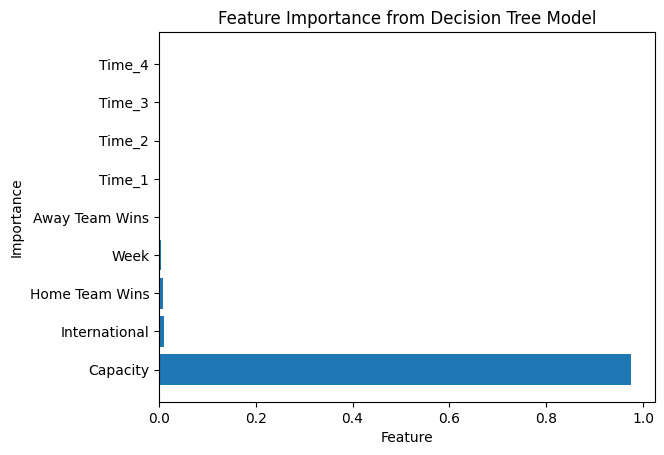

In [102]:
plt.barh(feature_imp["Feature"], feature_imp["Importance"])

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from Decision Tree Model")
plt.show

In the Decision Tree Model, Capacity accounted for nearly all of the feature importance in predicting fan attendance at NFL Games. Week of the game was the second most important variable in predicting attendance, followed by Number of Wins the Home Team had before the game.

In [103]:
# Saving model to local drive
filename = 'DecisionTree_model.sav'
pickle.dump(bestRegTree, open(filename, 'wb'))

# Random Forest Model

In [104]:
forest = RandomForestRegressor(random_state = 42)

# Start with an initial guess for parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20], 'min_samples_split': [5, 10, 20], 'min_samples_leaf': [5, 10, 20]}


In [45]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = RandomizedSearchCV(estimator = forest,
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'r2',
                              cv = folds,
                              verbose = 2,
                              random_state = 42,
                              n_jobs = -1)

In [46]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 195.96267747879028s


In [48]:
print(f"Initial score: {round(model_cv.best_score_, 4)}")
print(f"Initial parameters:{model_cv.best_params_}")

Initial score: 0.7752
Initial parameters:{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 10}


## Hyperparameter Tuning

In [105]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [3, 5, 7, 10],
    'min_samples_split': [3, 5, 7, 10],
    'n_estimators': [50, 75, 100, 125]
}

print(param_grid)

{'max_depth': [8, 10, 12, 15], 'min_samples_leaf': [3, 5, 7, 10], 'min_samples_split': [3, 5, 7, 10], 'n_estimators': [50, 75, 100, 125]}


In [106]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = forest,
                        param_grid = param_grid,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1)

# Re-fit the model
start = time.time()            # Start Time
model_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


C:\Users\petew\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training time: 169.29825687408447s


In [108]:
print(f"Improved score: {round(model_cv.best_score_, 4)}")
print(f"Improved parameters:{model_cv.best_params_}")

Improved score: 0.7758
Improved parameters:{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 75}


In [109]:
# Storing importance values from the best fit model
importance = model_cv.best_estimator_.feature_importances_

# Displaying feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_x.columns, importance.round(4))),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,Capacity,0.9188
1,Week,0.0322
2,Home Team Wins,0.0242
3,Away Team Wins,0.0160
4,International,0.0077
5,Time_1,0.0008
6,Time_2,0.0002
7,Time_3,0.0001
8,Time_4,0.0001


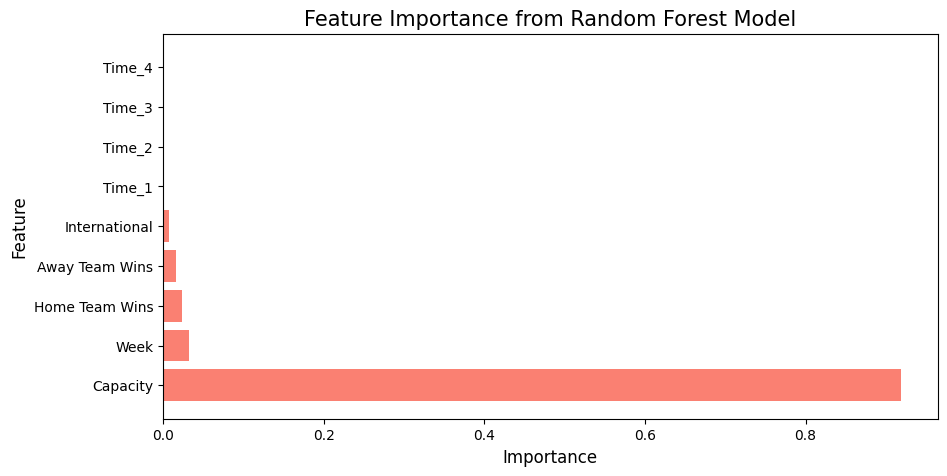

In [110]:
# Bar plot
plt.figure(figsize=(10, 5), dpi = 100)
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color ='salmon')

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Feature", fontsize = 12)
plt.title("Feature Importance from Random Forest Model", fontsize = 15);

In [111]:
RF_y_pred = model_cv.predict(test_x)

r2_test = sklearn.metrics.r2_score(test_y, RF_y_pred)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, RF_y_pred)

print('R-squared on Train Set: %0.2f' %r2_test)
print('RMSE on Train Set: %0.2f' %RMSE_train)

R-squared on Train Set: 0.80
RMSE on Train Set: 4465.28


Although the Random Forest model had a slightly higher R-squared than the Decision Tree model, the root mean square error is 1500 fans greater.

In [112]:
# Saving model to local drive
filename = 'RandomForest_model.sav'
pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))

# XGBoost Model

In [113]:
# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=99)

hyper_params = {
    'max_depth': [5, 10, 15, 20],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
}

folds = KFold(n_splits=5, shuffle=True, random_state=100)

# Set up GridSearchCV
xgb_cv = GridSearchCV(estimator=xgb_model,
                      param_grid=hyper_params,
                      scoring='r2',
                      cv=folds,
                      verbose=1,
                      n_jobs=-1)

In [59]:
# Fit the model using the training data
start = time.time()            # Start Time
xgb_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\petew\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=99, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 10, 15, 20],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [60]:
print(f"Initial score: {round(xgb_cv.best_score_, 4)}")
print(f"Initial parameters: {xgb_cv.best_params_}")

Initial score: 0.7727
Initial parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


In [61]:
# Adapt grid based on results from initial grid search
hyper_params_new = {
    'max_depth': [3, 5, 7, 8],
    'min_child_weight': [4, 5, 6, 7],
    'learning_rate': [0.025, 0.05, 0.075],
    'n_estimators': [75, 100, 125, 150],
    'subsample': [0.7, 0.8, 0.9],
}

xgb_cv = GridSearchCV(estimator=xgb_model,
                      param_grid=hyper_params_new,
                      scoring='r2',
                      cv=folds,
                      verbose=1,
                      n_jobs=-1)


In [62]:
# Re-fit the model with the new parameters
start = time.time()            # Start Time
xgb_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Training time: 203.33275961875916s


In [63]:
print(f"Improved score: {round(xgb_cv.best_score_, 4)}")
print(f"Improved parameters: {xgb_cv.best_params_}")

Improved score: 0.7765
Improved parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 75, 'subsample': 0.8}


In [114]:
# Adapt grid based on results from second grid search
hyper_params_new = {
    'max_depth': [6, 7, 8, 9],
    'min_child_weight': [6, 7, 8, 9, 10],
    'learning_rate': [0.05],
    'n_estimators': [50, 65, 75, 85],
    'subsample': [0.8],
}

xgb_cv = GridSearchCV(estimator=xgb_model,
                      param_grid=hyper_params_new,
                      scoring='r2',
                      cv=folds,
                      verbose=1,
                      n_jobs=-1)


In [115]:
# Re-fit the model with the new parameters
start = time.time()            # Start Time
xgb_cv.fit(train_x, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Training time: 13.969906091690063s


In [116]:
print(f"Improved score: {round(xgb_cv.best_score_, 4)}")
print(f"Improved parameters: {xgb_cv.best_params_}")

Improved score: 0.7766
Improved parameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 75, 'subsample': 0.8}


In [117]:
# Performance Measures for Training Data
y_pred_train = xgb_cv.predict(train_x)
r2_train = sklearn.metrics.r2_score(train_y, y_pred_train)
rmse_train = sklearn.metrics.root_mean_squared_error(train_y, y_pred_train)
print(f"R Squared (Train): {round(r2_train, 4)}")
print(f"Root Mean Squared Error (Train): {round(rmse_train, 4)}")

R Squared (Train): 0.8633
Root Mean Squared Error (Train): 2546.063


In [118]:
# Performance Measures for Test Data
y_pred_test = xgb_cv.predict(test_x)
r2_test = sklearn.metrics.r2_score(test_y, y_pred_test)
rmse_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred_test)
print(f"R Squared (Test): {round(r2_test, 4)}")
print(f"Root Mean Squared Error (Test): {round(rmse_test, 4)}")

R Squared (Test): 0.816
Root Mean Squared Error (Test): 3067.6839


The XGBoost model is the best performing model in terms of R-Squared and Root Mean Squared Error. The model slightly overfit for the training data, but the testing data still performed phenomenally.

In [119]:
# Extract feature importances
xgb_importance = xgb_cv.best_estimator_.feature_importances_

# Display feature importance as a DataFrame
feature_imp = pd.DataFrame(list(zip(train_x.columns, xgb_importance)),
                           columns=['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_imp

,Feature,Importance
0,Capacity,0.566886
1,International,0.215702
2,Week,0.044259
3,Home Team Wins,0.041121
4,Away Team Wins,0.031471
5,Time_1,0.030461
6,Time_2,0.025721
7,Time_3,0.024688
8,Time_4,0.019692


Unlike the Decision Tree and Random Forest Models, Capacity accounted for much less of the importance in predicting fan Attendance. International played a solid role as well.

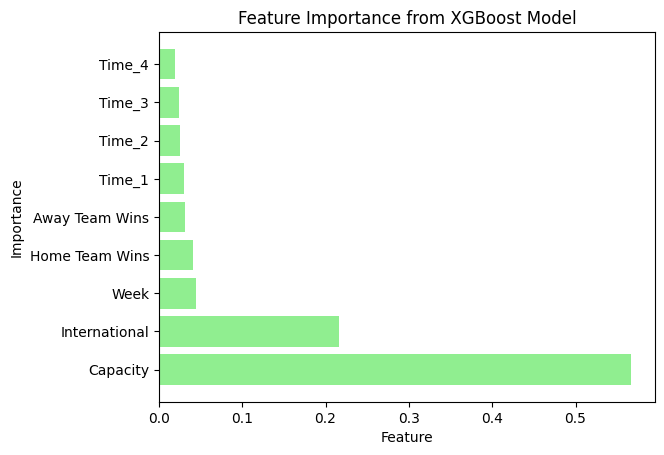

In [120]:
# Plotting feature importance
plt.barh(feature_imp["Feature"], feature_imp["Importance"], color = "lightgreen")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance from XGBoost Model")
plt.show()

In [121]:
# Saving model to local drive
filename = 'XGBoost_model.sav'
pickle.dump(xgb_cv.best_estimator_, open(filename, 'wb'))

# Voting Emsemble

In [122]:
decision_tree = pickle.load(open("DecisionTree_model.sav", 'rb'))
random_forest = pickle.load(open("RandomForest_model.sav", 'rb'))
xgboost = pickle.load(open("XGBoost_model.sav", 'rb'))

In [123]:
voting_regressor = VotingRegressor(estimators=[("Decision Tree", decision_tree),
                                               ("Random Forest", random_forest),
                                               ("XGBoost", xgboost)])


In [124]:
voting_regressor.fit(train_x, train_y)

VotingRegressor(estimators=[('Decision Tree',
                             DecisionTreeRegressor(max_depth=8,
                                                   min_samples_leaf=8,
                                                   min_samples_split=60,
                                                   random_state=99)),
                            ('Random Forest',
                             RandomForestRegressor(max_depth=8,
                                                   min_samples_leaf=5,
                                                   min_samples_split=3,
                                                   n_estimators=75,
                                                   random_state=42)),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=8,
                                          max_leaves=None, min_child_weight=9,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=75,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=99, ...))])

In [125]:
# Performance Measures for Training Data
y_pred_train = voting_regressor.predict(train_x)
r2_train = sklearn.metrics.r2_score(train_y, y_pred_train)
rmse_train = sklearn.metrics.root_mean_squared_error(train_y, y_pred_train)
print(f"R Squared (Train): {round(r2_train, 4)}")
print(f"Root Mean Squared Error (Train): {round(rmse_train, 4)}")

R Squared (Train): 0.837
Root Mean Squared Error (Train): 2781.0577


In [126]:
# Performance Measures for Test Data
y_pred_test = voting_regressor.predict(test_x)
r2_test = sklearn.metrics.r2_score(test_y, y_pred_test)
rmse_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred_test)
print(f"R Squared (Test): {round(r2_test, 4)}")
print(f"Root Mean Squared Error (Test): {round(rmse_test, 4)}")

R Squared (Test): 0.8123
Root Mean Squared Error (Test): 3097.9624


In [154]:
# Saving model to local drive
filename = 'VotingRegressor.sav'
pickle.dump(voting_regressor, open(filename, 'wb'))

## Weighted Voting Ensemble

In [146]:
# Weights correspond to individual model performance.
voting_regressor_weighted = VotingRegressor(estimators=[("Decision Tree", decision_tree),
                                               ("Random Forest", random_forest),
                                               ("XGBoost", xgboost)],
                                            weights = [0.1, 0.1, 0.8],
                                            n_jobs = -1)
voting_regressor_weighted.fit(train_x, train_y)

VotingRegressor(estimators=[('Decision Tree',
                             DecisionTreeRegressor(max_depth=8,
                                                   min_samples_leaf=8,
                                                   min_samples_split=60,
                                                   random_state=99)),
                            ('Random Forest',
                             RandomForestRegressor(max_depth=8,
                                                   min_samples_leaf=5,
                                                   min_samples_split=3,
                                                   n_estimators=75,
                                                   random_state=42)),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=8,
                                          max_leaves=None, min_child_weight=9,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=75,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=99, ...))],
                n_jobs=-1, weights=[0.1, 0.1, 0.8])

In [147]:
# Performance Measures for Training Data
y_pred_train = voting_regressor_weighted.predict(train_x)
r2_train = sklearn.metrics.r2_score(train_y, y_pred_train)
rmse_train = sklearn.metrics.root_mean_squared_error(train_y, y_pred_train)
print(f"R Squared (Train): {round(r2_train, 4)}")
print(f"Root Mean Squared Error (Train): {round(rmse_train, 4)}")

R Squared (Train): 0.8572
Root Mean Squared Error (Train): 2602.6996


In [148]:
# Performance Measures for Test Data
y_pred_test = voting_regressor_weighted.predict(test_x)
r2_test = sklearn.metrics.r2_score(test_y, y_pred_test)
rmse_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred_test)
print(f"R Squared (Test): {round(r2_test, 4)}")
print(f"Root Mean Squared Error (Test): {round(rmse_test, 4)}")

R Squared (Test): 0.8165
Root Mean Squared Error (Test): 3063.7406


The ensemble performed slightly better than XGBoost for the test data, but considering performance on both test and train data, XGBoost was the winner.

In [153]:
# Saving model to local drive
filename = 'VotingRegressorWeighted.sav'
pickle.dump(voting_regressor_weighted, open(filename, 'wb'))